In [1]:
import os
import shutil
import librosa
import soundfile as sf
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Parámetros
SAMPLE_RATE = 16000
DURATION = 1  # segundos
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MFCC = 13
N_FFT = 512
HOP_LENGTH = 256
EXPECTED_FRAMES = 1 + (SAMPLES_PER_TRACK - N_FFT) // HOP_LENGTH  # ≈ 61

# Directorio base
DATASET_PATH = 'dataset_final'  # Cambiá si hace falta

# Inicializamos
X = []
y = []

# Procesamos audios
for label in sorted(os.listdir(DATASET_PATH)):
    label_path = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(label_path):
        continue

    for file in tqdm(os.listdir(label_path), desc=f"Procesando {label}"):
        file_path = os.path.join(label_path, file)

        try:
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Pad o truncar a 1 segundo
            if len(signal) < SAMPLES_PER_TRACK:
                pad_width = SAMPLES_PER_TRACK - len(signal)
                signal = np.pad(signal, (0, pad_width), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_TRACK]

            # Extraer MFCCs
            mfcc = librosa.feature.mfcc(
                y=signal,
                sr=sr,
                n_mfcc=N_MFCC,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH
            )

            # Asegurar tamaño (61, 13)
            if mfcc.shape[1] < EXPECTED_FRAMES:
                pad_width = EXPECTED_FRAMES - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            elif mfcc.shape[1] > EXPECTED_FRAMES:
                mfcc = mfcc[:, :EXPECTED_FRAMES]

            # Agregar a listas
            X.append(mfcc.T)  # Transponer para (frames, coeficientes)
            y.append(label)

        except Exception as e:
            print(f"Error con {file_path}: {e}")

# Convertimos a arrays
X = np.array(X, dtype=np.float32)
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Clases: {le.classes_}")


Procesando yes: 100%|██████████| 4044/4044 [00:39<00:00, 101.87it/s]


X shape: (8585, 61, 13), y shape: (8585,)
Clases: ['aplauso' 'no' 'silencio' 'yes']


In [95]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# Crear diccionario para codificar etiquetas
labels = sorted(set(y))  # Obtener todas las clases únicas en orden alfabético
label_to_index = {label: idx for idx, label in enumerate(labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Asegurarse de que X tiene la forma (samples, 61, 13, 1)
X = np.expand_dims(X, -1)

# Codificar etiquetas
y_encoded = to_categorical([label_to_index[label] for label in y])

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)


In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

input_shape = (61, 13, 1)
num_classes = y_train.shape[1]  # ya está one-hot

# Definir el modelo Teacher (MLP grande)
def build_teacher():
    model = Sequential([
        Flatten(input_shape=input_shape),         # Aplana (61,13,1) → (793,)
        Dense(512, activation="relu"),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(num_classes, activation="softmax")  # Adaptado al nro de clases
    ])
    return model

# Compilar y entrenar
teacher = build_teacher()
teacher.summary()

teacher.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = teacher.fit(
    X_train, y_train,
    epochs=16,
    batch_size=128,
    validation_data=(X_test, y_test)
)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 793)               0         
                                                                 
 dense_60 (Dense)            (None, 512)               406528    
                                                                 
 dense_61 (Dense)            (None, 512)               262656    
                                                                 
 dense_62 (Dense)            (None, 256)               131328    
                                                                 
 dense_63 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 801,540
Trainable params: 801,540
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
54/54 [=============================

In [97]:
# Definir el modelo Student (más chico)
def build_student():
    model = Sequential([
        Flatten(input_shape=(61, 13, 1)),   # Misma entrada
        Dense(8, activation="relu"), 
        Dense(32, activation="relu"), 
        Dense(64, activation="relu"),    # Mucho más liviano
        Dense(32, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

student = build_student()
student.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 793)               0         
                                                                 
 dense_64 (Dense)            (None, 8)                 6352      
                                                                 
 dense_65 (Dense)            (None, 32)                288       
                                                                 
 dense_66 (Dense)            (None, 64)                2112      
                                                                 
 dense_67 (Dense)            (None, 32)                2080      
                                                                 
 dense_68 (Dense)            (None, 4)                 132       
                                                                 
Total params: 10,964
Trainable params: 10,964
Non-tra

In [98]:
from distillationClassKeras import Distiller

train_labels = np.argmax(y_train, axis=1)

distilledMLP = Distiller(student=student, teacher=teacher)

In [99]:
distilledMLP.student.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 793)               0         
                                                                 
 dense_64 (Dense)            (None, 8)                 6352      
                                                                 
 dense_65 (Dense)            (None, 32)                288       
                                                                 
 dense_66 (Dense)            (None, 64)                2112      
                                                                 
 dense_67 (Dense)            (None, 32)                2080      
                                                                 
 dense_68 (Dense)            (None, 4)                 132       
                                                                 
Total params: 10,964
Trainable params: 10,964
Non-tra

In [100]:
# Proceso de destilación del conocimiento
import keras
from tensorflow.keras.optimizers import SGD, Adam

adam = Adam(0.0001)
distilledMLP.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1, 
        temperature=10,
    )

history = distilledMLP.fit(X_train, train_labels, validation_split=0.2, batch_size = 64, epochs= 32)

Epoch 1/32


/Users/demian/miniforge3/envs/ml_env/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/86 [==============================] - 2s 14ms/step - sparse_categorical_accuracy: 0.3371 - student_loss: 8.3488 - distillation_loss: 0.0013 - val_sparse_categorical_accuracy: 0.4782 - val_student_loss: 3.2107
Epoch 2/32
86/86 [==============================] - 1s 9ms/step - sparse_categorical_accuracy: 0.4603 - student_loss: 1.9993 - distillation_loss: 9.8199e-04 - val_sparse_categorical_accuracy: 0.4789 - val_student_loss: 1.9115
Epoch 3/32
86/86 [==============================] - 1s 10ms/step - sparse_categorical_accuracy: 0.4598 - student_loss: 1.4937 - distillation_loss: 9.4386e-04 - val_sparse_categorical_accuracy: 0.4782 - val_student_loss: 1.6276
Epoch 4/32
86/86 [==============================] - 1s 10ms/step - sparse_categorical_accuracy: 0.4594 - student_loss: 1.3769 - distillation_loss: 9.2223e-04 - val_sparse_categorical_accuracy: 0.4782 - val_student_loss: 1.4570
Epoch 5/32
86/86 [==============================] - 1s 10ms/step - sparse_categorical_accuracy: 0.4600 - stu

dict_keys(['sparse_categorical_accuracy', 'student_loss', 'distillation_loss', 'val_sparse_categorical_accuracy', 'val_student_loss'])


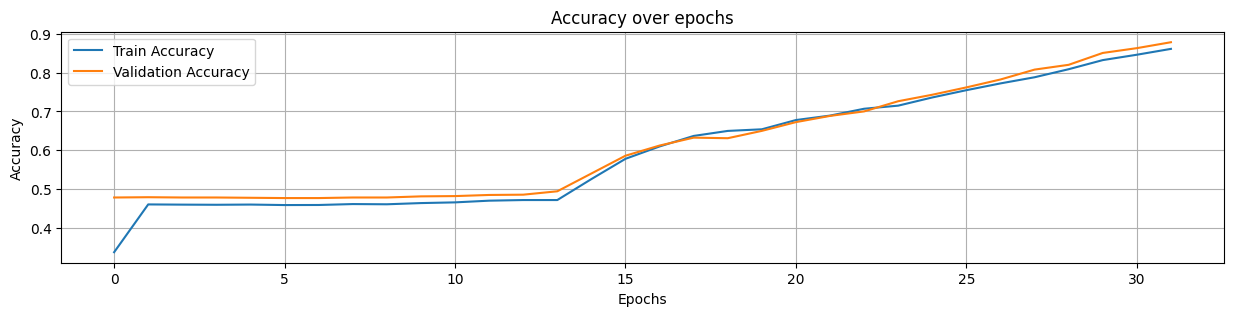

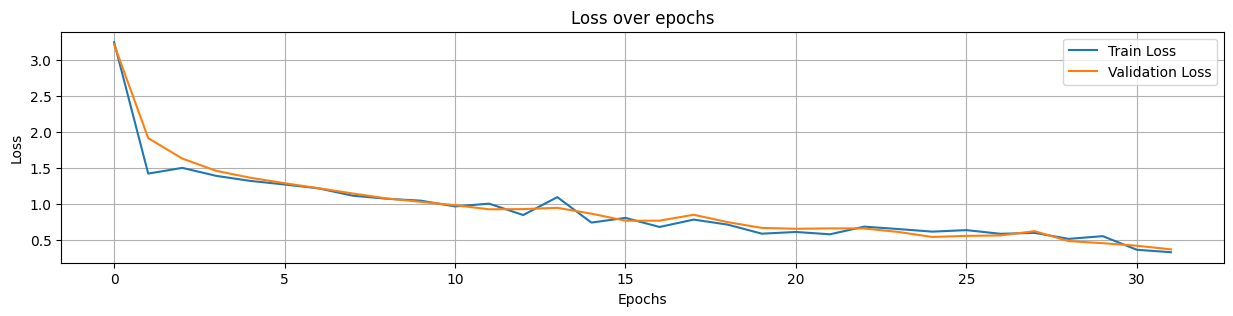

54/54 [==============================] - 0s 2ms/step


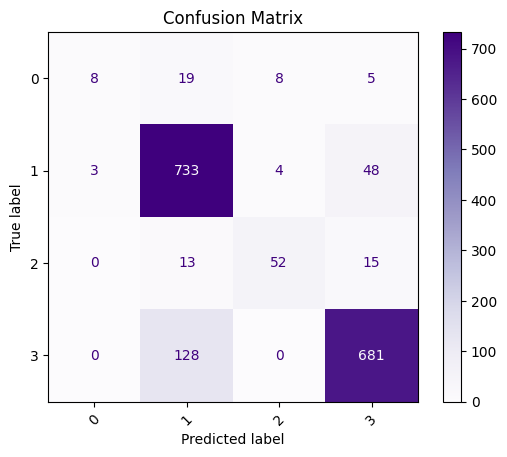

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Recomendado: revisar qué métricas y losses tenés disponibles
print(history.history.keys())

# Plot accuracy over epochs
plt.figure(figsize=(15, 3))
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.grid(True)
plt.show()

# Plot loss over epochs
plt.figure(figsize=(15, 3))
plt.plot(history.history['student_loss'], label='Train Loss')
plt.plot(history.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.grid(True)
plt.show()

# Evaluar el modelo en test
y_pred_probs = distilledMLP.student.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas reales
# Si y_test ya está en índices, no hagas nada
# Si está en one-hot, usá:
if y_test.shape[-1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Mostrar matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Si tenés el diccionario label_to_index, podés mostrar los nombres de las clases
try:
    labels = list(label_to_index.keys())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
except:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Purples', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [102]:
distilledMLP.student.save("models/reconocimiento_KD.h5")

In [107]:
import tensorflow_model_optimization as tfmot
from qkeras import QDense, QActivation, quantized_bits
from tensorflow.keras.layers import Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# Parámetros de cuantización
kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8, 4,alpha=1)"
activationQ = 'quantized_bits(8, 4)'

# Sparsity final deseada
final_sparsity = 0.9
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=final_sparsity,
        begin_step=0,
        end_step=3000
    )
}

# Modelo Student cuantizado y podado
student_quantized = Sequential([
    Flatten(input_shape=(61, 13, 1)),  # Adaptado a tu input shape
    QDense(8, kernel_quantizer=kernelQ, bias_quantizer=biasQ, kernel_initializer='lecun_uniform'),
    QActivation(activation=activationQ),
    Dropout(0.2),

    QDense(32, kernel_quantizer=kernelQ, bias_quantizer=biasQ, kernel_initializer='lecun_uniform'),
    QActivation(activation=activationQ),
    Dropout(0.2),

    QDense(64, kernel_quantizer=kernelQ, bias_quantizer=biasQ, kernel_initializer='lecun_uniform'),
    QActivation(activation=activationQ),
    Dropout(0.2),

    QDense(32, kernel_quantizer=kernelQ, bias_quantizer=biasQ, kernel_initializer='lecun_uniform'),
    QActivation(activation=activationQ),
    Dropout(0.2),

    QDense(4, kernel_quantizer=kernelQ, bias_quantizer=biasQ, kernel_initializer='lecun_uniform'),
    Activation('softmax')

], name="student_quantized")


In [108]:
# Aplicar pruning
student_qap = tfmot.sparsity.keras.prune_low_magnitude(student_quantized, **pruning_params)

In [109]:
# Compilar y entrenar
student_qap.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=["accuracy"])

history_qap = student_qap.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=16,
    batch_size=64,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()],
    verbose=1
)


Epoch 1/16
86/86 [==============================] - 8s 57ms/step - loss: 4.3420 - accuracy: 0.4680 - val_loss: 1.7354 - val_accuracy: 0.6470
Epoch 2/16
86/86 [==============================] - 4s 42ms/step - loss: 2.4518 - accuracy: 0.5137 - val_loss: 1.1745 - val_accuracy: 0.6616
Epoch 3/16
86/86 [==============================] - 3s 39ms/step - loss: 1.8927 - accuracy: 0.5419 - val_loss: 0.8940 - val_accuracy: 0.7183
Epoch 4/16
86/86 [==============================] - 3s 39ms/step - loss: 1.5496 - accuracy: 0.5559 - val_loss: 0.8742 - val_accuracy: 0.7205
Epoch 5/16
86/86 [==============================] - 3s 39ms/step - loss: 1.4010 - accuracy: 0.5593 - val_loss: 0.7479 - val_accuracy: 0.6499
Epoch 6/16
86/86 [==============================] - 3s 39ms/step - loss: 1.2796 - accuracy: 0.5604 - val_loss: 0.7683 - val_accuracy: 0.7271
Epoch 7/16
86/86 [==============================] - 3s 40ms/step - loss: 1.1513 - accuracy: 0.6050 - val_loss: 0.8131 - val_accuracy: 0.6557
Epoch 8/16
86

In [110]:
student_qap.summary()

Model: "student_quantized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 793)              1         
 _24 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_q_dense  (None, 8)                12698     
 _26 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_q_activ  (None, 8)                1         
 ation_18 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_dropout  (None, 8)                1         
 _18 (PruneLowMagnitude)                                         
                                                 

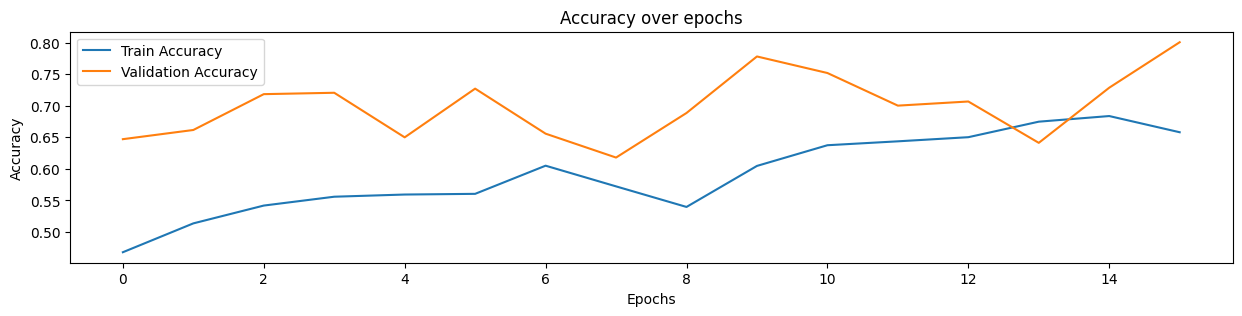

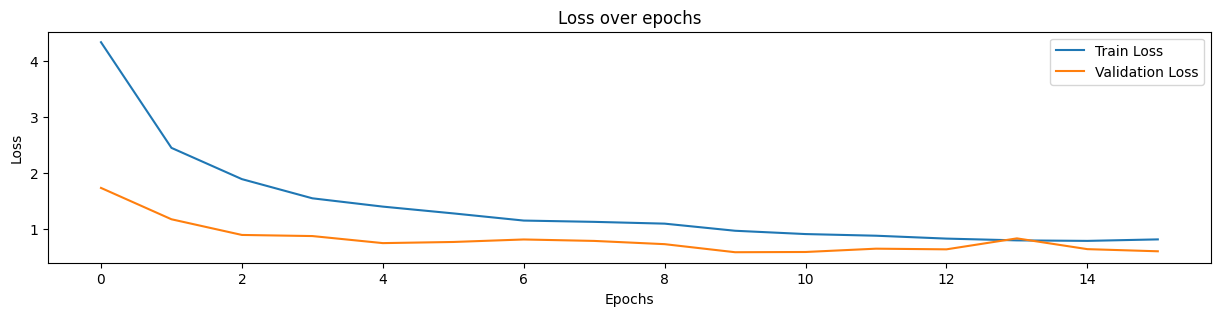

In [111]:
# Accuracy
plt.figure(figsize=(15, 3))
plt.plot(history_qap.history['accuracy'], label='Train Accuracy')
plt.plot(history_qap.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Loss
plt.figure(figsize=(15, 3))
plt.plot(history_qap.history['loss'], label='Train Loss')
plt.plot(history_qap.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()


54/54 [==============================] - 1s 13ms/step


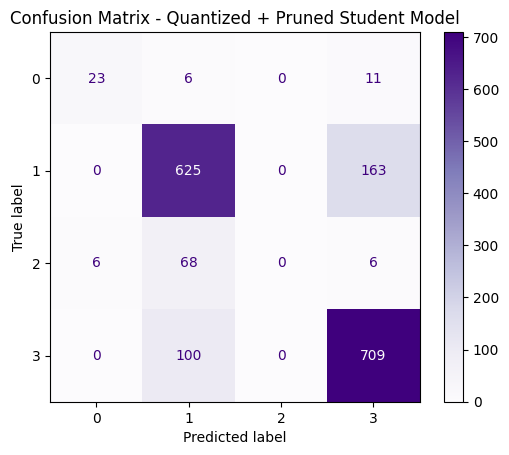

In [112]:
# Predecimos
y_pred_probs = student_qap.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convertimos etiquetas one-hot a enteros
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix - Quantized + Pruned Student Model')
plt.show()

In [113]:
# Eliminar los wrappers de pruning para dejar el modelo limpio
final_model = tfmot.sparsity.keras.strip_pruning(student_qap)

# Guardar como modelo completo (puede cargar luego con keras.models.load_model)
final_model.save("student_qap_final.h5")

final_model.summary()

Model: "student_quantized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 793)               0         
                                                                 
 q_dense_26 (QDense)         (None, 8)                 6352      
                                                                 
 q_activation_18 (QActivatio  (None, 8)                0         
 n)                                                              
                                                                 
 dropout_18 (Dropout)        (None, 8)                 0         
                                                                 
 q_dense_27 (QDense)         (None, 32)                288       
                                                                 
 q_activation_19 (QActivatio  (None, 32)               0         
 n)                                              